In [276]:
import tensorflow as tf
assert tf.__version__ == "2.3.0"

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import pydot

from IPython import display

In [277]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)


train_images.shape: (60000, 28, 28)
train_labels.shape: (60000,)


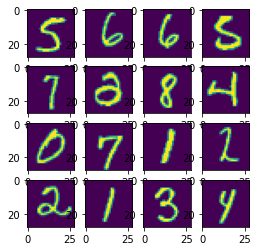

In [278]:
plt.figure(figsize=(4,4))
random_idx = np.random.randint(train_images.shape[0] - 16)
for idx1, idx2 in zip(range(16), tf.range(random_idx, random_idx + 16)):
    plt.subplot(4, 4, idx1+1)
    plt.imshow(train_images[idx2, :, :])

Normalization

In [279]:
BATCH_SIZE = 128

train_images = train_images.astype(np.float32)
train_images = train_images.reshape([train_images.shape[0], 28, 28, 1])
train_images = train_images / np.max(train_images)

train_set = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [280]:
def build_generator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256 * 7 * 7, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(target_shape = [7, 7, 256]),
# ---- this layer will break the GAN
#         tf.keras.layers.Conv2DTranspose(256, kernel_size=(5,5), strides=(1,1), padding="same", use_bias=False),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2), padding="same"),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("tanh"),
    ])
    
    return model

generator = build_generator()

generator.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_98 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_29 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_99 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_99 (LeakyReLU)   (None, 7, 7, 128)       

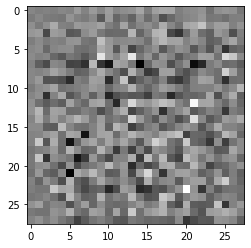

In [281]:
gen_input = tf.random.normal([2,100])
gen_output = generator(gen_input)
plt.imshow(gen_output[0, :, :, 0], cmap="gray")

In [282]:
def build_discriminator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding="same", input_shape=(28,28,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
    ])
    
    return model

discriminator = build_discriminator()

discriminator.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_101 (Bat (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_102 (Bat (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 7, 7, 128)       

In [283]:
print(discriminator(gen_output))

tf.Tensor(
[[-0.00354313]
 [-0.00126031]], shape=(2, 1), dtype=float32)


In [284]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [285]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss+fake_loss

def generator_loss(gen_output):
    gen_loss = cross_entropy(tf.ones_like(gen_output), gen_output)
    return gen_loss



In [286]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discrimanator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [287]:
GENERATOR_DIMS = 100
NUM_EXAMPLES_TO_GEN = 16
EPOCHS = 50

seed = tf.random.normal([NUM_EXAMPLES_TO_GEN, GENERATOR_DIMS])
seed.shape

TensorShape([16, 100])

In [288]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, GENERATOR_DIMS])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_images = generator(noise, training=True)
        discriminator_fake = discriminator(generator_images, training=True)
        discriminator_real = discriminator(images, training=True)
        
        gen_loss = generator_loss(discriminator_fake)
        disc_loss = discriminator_loss(discriminator_real, discriminator_fake)
    
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discrimanator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    

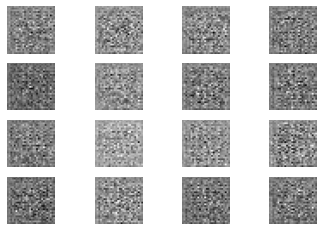

seed images min/mean/max: -0.10236037 -0.0035487565 0.08816127


In [289]:
def generate_and_save_images(model, epoch_id, noise):
    prediction = model(noise)
    
    for i in range(prediction.shape[0]):
        plt.subplot(
            prediction.shape[0] // 4,
            prediction.shape[0] // 4,
            i+1
        )
        plt.imshow(prediction[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.show()

    print("seed images min/mean/max:", tf.reduce_min(prediction).numpy(), tf.reduce_mean(prediction).numpy(), tf.reduce_max(prediction).numpy())
    
generate_and_save_images(generator, 0, seed)

In [290]:
def train(dataset, epochs):
    for idx in tf.range(epochs):
        start = time.time()
        for dataset_batch in dataset:
            train_step(dataset_batch)
            
        
        seed = tf.random.normal([NUM_EXAMPLES_TO_GEN, GENERATOR_DIMS])
#         display.clear_output(wait=True)

        generate_and_save_images(generator, idx, seed)

        print("time for epoch {} is {}".format(idx, start - time.time()))


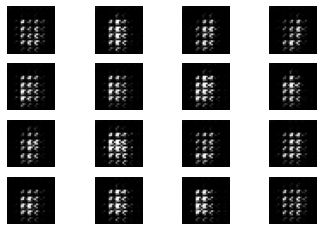

seed images min/mean/max: -0.9999996 -0.8536532 0.997412
time for epoch 0 is -422.84684920310974


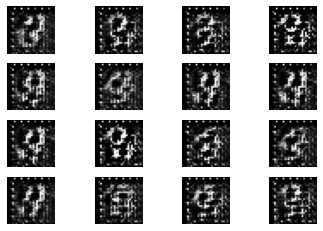

seed images min/mean/max: -1.0 -0.6469302 0.99989665
time for epoch 1 is -405.20454955101013


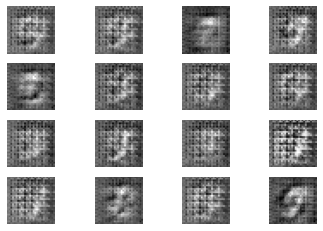

seed images min/mean/max: -0.9712848 -0.117555134 0.9574609
time for epoch 2 is -390.084091424942


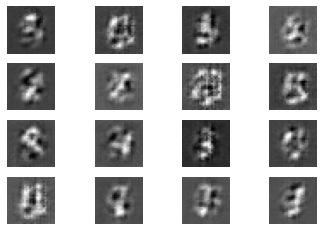

seed images min/mean/max: -0.6305379 -0.18480547 0.6955813
time for epoch 3 is -376.88906931877136


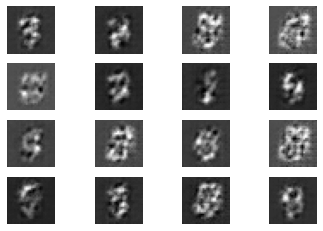

seed images min/mean/max: -0.7000148 -0.18631488 0.7316845
time for epoch 4 is -376.8450491428375


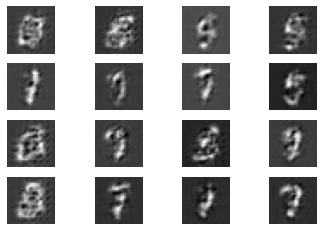

seed images min/mean/max: -0.5827313 -0.18220812 0.77812886
time for epoch 5 is -376.6047921180725


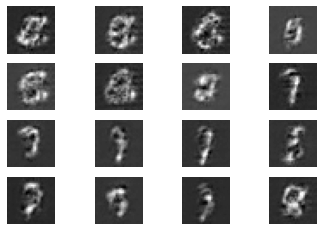

seed images min/mean/max: -0.51198745 -0.17633188 0.6003603
time for epoch 6 is -377.33625888824463


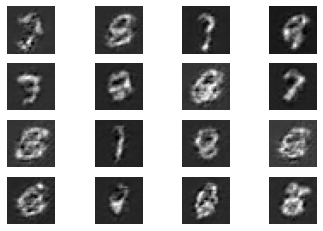

seed images min/mean/max: -0.47188345 -0.1636151 0.71606797
time for epoch 7 is -389.1499514579773


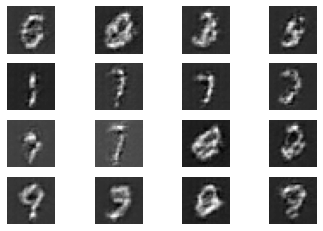

seed images min/mean/max: -0.5925979 -0.18901977 0.6381207
time for epoch 8 is -393.74132013320923


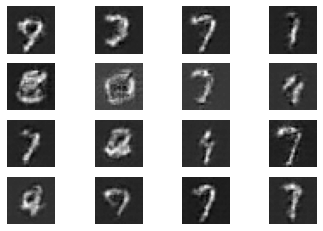

seed images min/mean/max: -0.5768444 -0.1815295 0.73555493
time for epoch 9 is -399.7251739501953


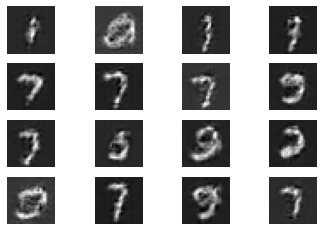

seed images min/mean/max: -0.4960527 -0.17954268 0.66471416
time for epoch 10 is -403.0818884372711


KeyboardInterrupt: 

In [291]:
train(train_set, EPOCHS)

In [ ]:
seed_images = generator(seed)

1) remove use_bias=False from generator
2) move dataset from (-1, 1) -> (0, 1)
3) default optimizer step
4) replace loss from tf.losses -> tf.keras.losses
5) add one more layer to generator
6) training = True from train_step


In [ ]:
for dsb in train_set:
    print(tf.reduce_min(dsb).numpy(), tf.reduce_mean(dsb).numpy(), tf.reduce_max(dsb).numpy() )

